In [103]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import pandas
import iris
import iris.iterate
import iris.pandas
import iris.coord_categorisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import glob

import scipy

In [71]:
%matplotlib inline

## Read data

In [5]:
tfile = '/g/data/ua6/DRSv3/CMIP5/CCSM4/historicalGHG/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_CCSM4_historicalGHG_r1i1p1_200001-200512.nc'
vfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/volcello/latest/volcello-inferred_fx_CCSM4_historical_r0i0p0.nc'
bfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/basin/latest/basin_fx_CCSM4_historical_r0i0p0.nc'

In [6]:
tcube = iris.load_cube(tfile)
vcube = iris.load_cube(vfile)
bcube = iris.load_cube(bfile)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))


In [7]:
tcube = tcube.collapsed('time', iris.analysis.MEAN)
tcube.data = tcube.data - 273.15

In [10]:
tdata = tcube.data.flatten()
vdata = vcube.data.flatten()
bdata = bcube.data.flatten()

In [12]:
df = pandas.DataFrame(index=range(tdata.shape[0]))
df['temperature'] = tdata.filled(fill_value=5000)
df['volume'] = vdata.filled(fill_value=5000)
df['basin'] = bdata.filled(fill_value=5000)

In [14]:
df = df[df.temperature != 5000]
df = df[df.temperature != -273.15]

## V(T), dV/dT

In [30]:
print(df['temperature'].values.min())
print(df['temperature'].values.max())

-2.3743896
30.204285


In [33]:
bin_edges = numpy.arange(-2.5, 31.5, 1)
bin_edges

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,
        8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5,
       19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5,
       30.5])

In [63]:
dvdt, edges, binnum = scipy.stats.binned_statistic(df['temperature'].values, df['volume'].values, statistic='sum', bins=bin_edges)

In [64]:
temps = (edges[1:] + edges[:-1]) / 2
temps

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28., 29., 30.])

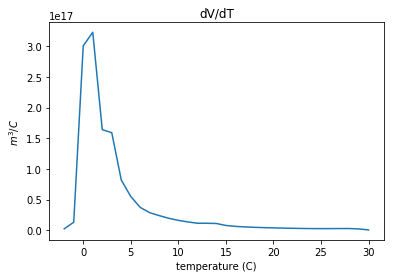

In [66]:
plt.plot(temps, dvdt)
plt.xlabel('temperature (C)')
plt.ylabel('$m^3 / C$')
plt.title('dV/dT')
plt.show()

In [67]:
vt = dvdt.cumsum()

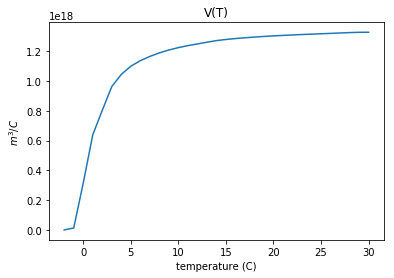

In [69]:
plt.plot(temps, vt)
plt.xlabel('temperature (C)')
plt.ylabel('$m^3 / C$')
plt.title('V(T)')
plt.show()

## dV/dt

In [73]:
infiles = glob.glob('/g/data/ua6/DRSv3/CMIP5/CCSM4/historicalGHG/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_CCSM4_historicalGHG_r1i1p1_??????-??????.nc')
infiles.sort()

In [ ]:
vt_timeseries = numpy.array([])
for infile in infiles:
    print(infile)
    tcube = iris.load_cube(infile)
    
    iris.coord_categorisation.add_year(tcube, 'time')
    iris.coord_categorisation.add_month(tcube, 'time')
    tcube = tcube.aggregated_by(['year'], iris.analysis.MEAN)
    tcube.remove_coord('year')
    tcube.remove_coord('month')
    
    tcube.data = tcube.data - 273.15
    
    for time_slice in tcube.slices_over('time'):
        tdata = time_slice.data.flatten()
        
        df = pandas.DataFrame(index=range(tdata.shape[0]))
        df['temperature'] = tdata.filled(fill_value=5000)
        df['volume'] = vdata.filled(fill_value=5000)

        df = df[df.temperature != 5000]
        df = df[df.temperature != -273.15]
        
        dvdt, edges, binnum = scipy.stats.binned_statistic(df['temperature'].values, df['volume'].values, statistic='sum', bins=bin_edges)
        vt = dvdt.cumsum()
        
        vt_timeseries = numpy.vstack([vt_timeseries, vt]) if vt_timeseries.size else vt
        